In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

In [2]:
train_data=pd.read_csv('.gitignore/train.csv')
train_data

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [3]:
test_data=pd.read_csv('.gitignore/test.csv')
test_data

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


In [4]:
store_data=pd.read_csv('.gitignore/stores.csv')
store_data.tail()

,store_nbr,city,state,type,cluster
49,50,Ambato,Tungurahua,A,14
50,51,Guayaquil,Guayas,A,17
51,52,Manta,Manabi,A,11
52,53,Manta,Manabi,D,13
53,54,El Carmen,Manabi,C,3


In [5]:
samplesub_data=pd.read_csv('.gitignore/sample_submission.csv')
samplesub_data.tail()

,id,sales
28507,3029395,0.0
28508,3029396,0.0
28509,3029397,0.0
28510,3029398,0.0
28511,3029399,0.0


In [6]:
oil_data=pd.read_csv('.gitignore/oil.csv')
oil_data.tail()

,date,dcoilwtico
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96
1217,2017-08-31,47.26


In [7]:
sales=train_data.groupby(['date','family'],as_index=False).agg(sales=('sales','sum'))
sales

,date,family,sales
0,2013-01-01,AUTOMOTIVE,0.000000
1,2013-01-01,BABY CARE,0.000000
2,2013-01-01,BEAUTY,2.000000
3,2013-01-01,BEVERAGES,810.000000
4,2013-01-01,BOOKS,0.000000
...,...,...,...
55567,2017-08-15,POULTRY,17586.709986
55568,2017-08-15,PREPARED FOODS,4641.522980
55569,2017-08-15,PRODUCE,125108.971000
55570,2017-08-15,SCHOOL AND OFFICE SUPPLIES,2530.000000


In [8]:
timeseries=sales.pivot(index='date', columns='family', values='sales')
# timeseries.to_csv('Store-Sales-Time-Series.csv')

Text(0, 0.5, 'Sales')

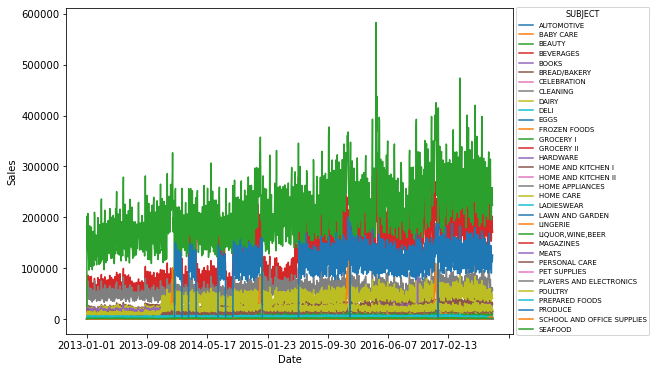

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

timeseries.plot(table=False, ax=ax);
ax.legend(title='SUBJECT',title_fontsize=8,prop={"size":7},loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Date')
plt.ylabel('Sales')

In [16]:
difference1=timeseries.diff(periods=1)
difference1=difference1[1:]

Text(0, 0.5, 'Sales')

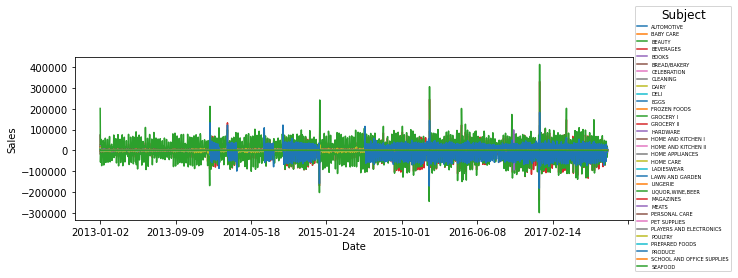

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
difference1.plot(table=False, ax=ax);
ax.legend(title='Subject',title_fontsize=12,prop={"size":5},loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Date')
plt.ylabel('Sales')

In [21]:
family_list=list(set(sales['family']))
family_list.sort()
family_list

['AUTOMOTIVE',
 'BABY CARE',
 'BEAUTY',
 'BEVERAGES',
 'BOOKS',
 'BREAD/BAKERY',
 'CELEBRATION',
 'CLEANING',
 'DAIRY',
 'DELI',
 'EGGS',
 'FROZEN FOODS',
 'GROCERY I',
 'GROCERY II',
 'HARDWARE',
 'HOME AND KITCHEN I',
 'HOME AND KITCHEN II',
 'HOME APPLIANCES',
 'HOME CARE',
 'LADIESWEAR',
 'LAWN AND GARDEN',
 'LINGERIE',
 'LIQUOR,WINE,BEER',
 'MAGAZINES',
 'MEATS',
 'PERSONAL CARE',
 'PET SUPPLIES',
 'PLAYERS AND ELECTRONICS',
 'POULTRY',
 'PREPARED FOODS',
 'PRODUCE',
 'SCHOOL AND OFFICE SUPPLIES',
 'SEAFOOD']

In [13]:
#Performing Augmented Dickey Fuller Test (ADF), if p values less then 0.05 we can say that time serias are stationary
for i in family_list:
    stationarty_test=adfuller(difference1[i])
    print('ADF=',stationarty_test[0],'-----','p=',stationarty_test[1],'---',i)

ADF= -13.110313085080824 ----- p= 1.6399989234827264e-24 --- AUTOMOTIVE
ADF= -12.05616313404684 ----- p= 2.5306836632180795e-22 --- BABY CARE
ADF= -14.02364417802245 ----- p= 3.534887706828185e-26 --- BEAUTY
ADF= -9.963734738540593 ----- p= 2.336601893056968e-17 --- BEVERAGES
ADF= -8.864461248504886 ----- p= 1.4530575720345984e-14 --- BOOKS
ADF= -12.729786899346829 ----- p= 9.429731032910193e-24 --- BREAD/BAKERY
ADF= -10.629608012678815 ----- p= 5.255748533776835e-19 --- CELEBRATION
ADF= -16.846717860025713 ----- p= 1.126974951991007e-29 --- CLEANING
ADF= -11.875018828704384 ----- p= 6.371072222681003e-22 --- DAIRY
ADF= -14.928786281425142 ----- p= 1.3762667661744467e-27 --- DELI
ADF= -12.074993200166848 ----- p= 2.301142908886562e-22 --- EGGS
ADF= -11.524395714947406 ----- p= 3.9684518571295996e-21 --- FROZEN FOODS
ADF= -13.277610158904283 ----- p= 7.808187316736944e-25 --- GROCERY I
ADF= -10.06312616975058 ----- p= 1.3174318251476792e-17 --- GROCERY II
ADF= -10.674763960558947 ----- 

C:\Users\okanc\anaconda3\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


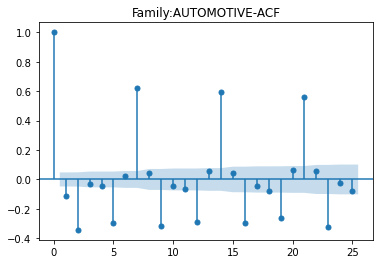

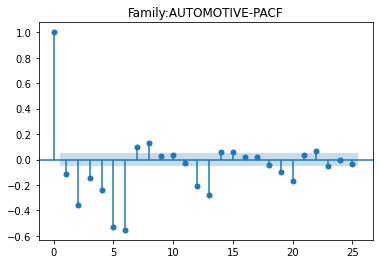

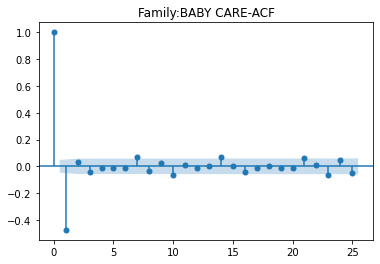

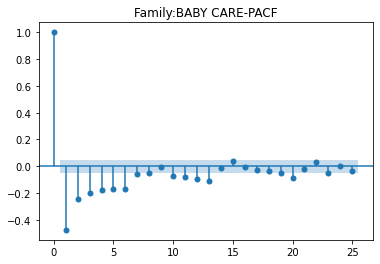

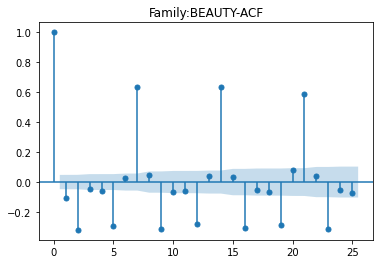

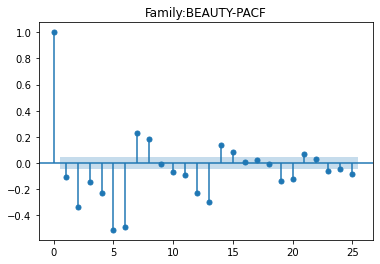

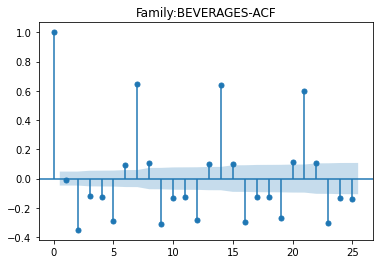

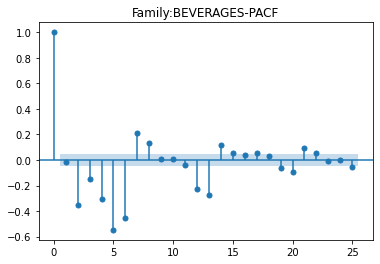

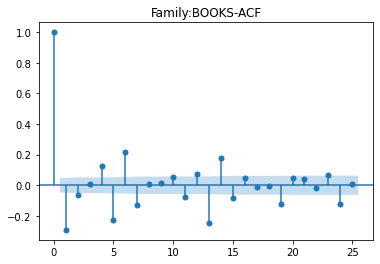

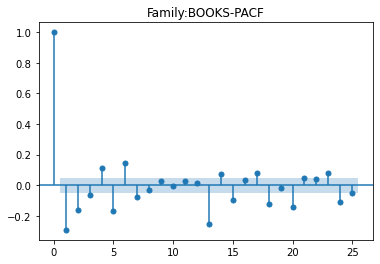

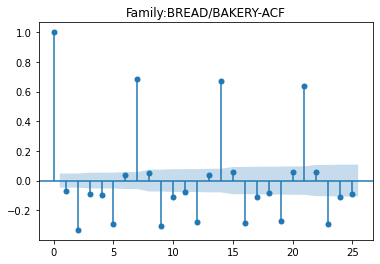

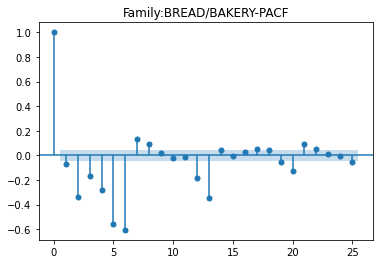

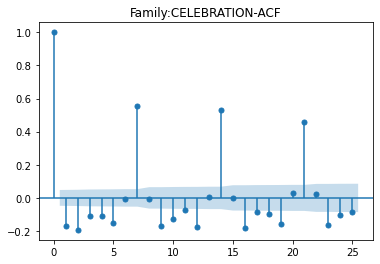

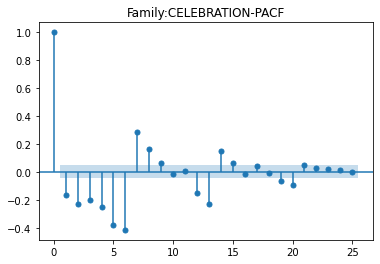

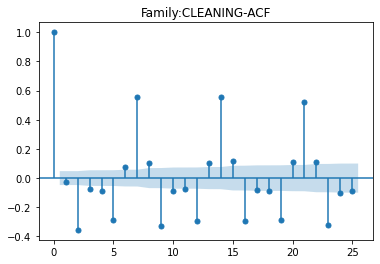

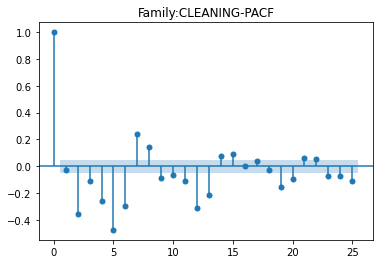

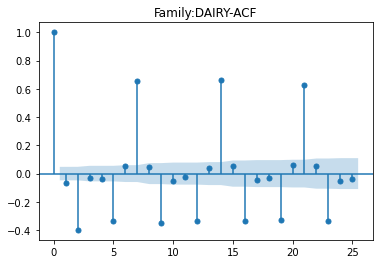

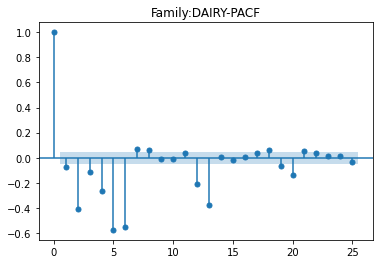

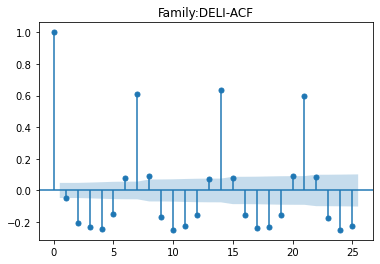

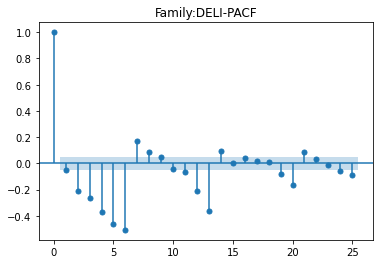

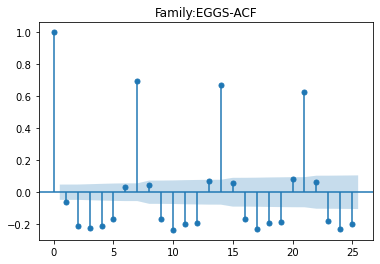

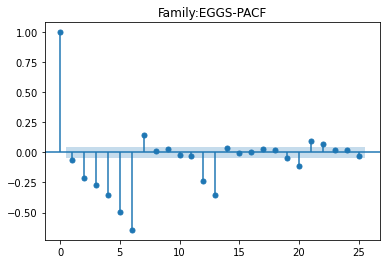

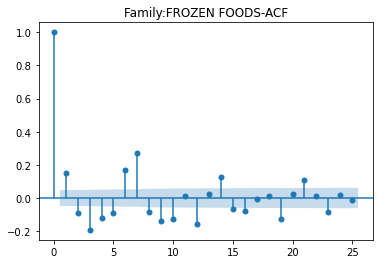

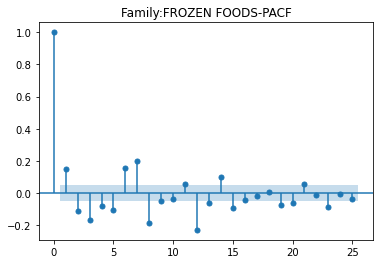

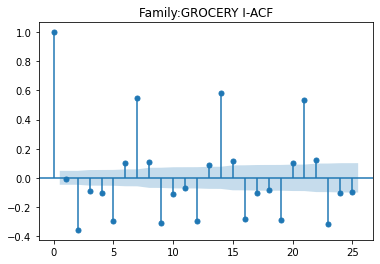

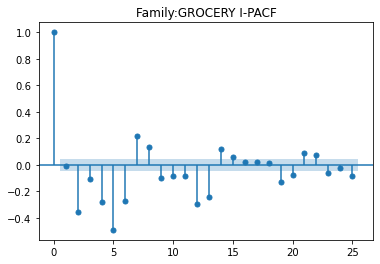

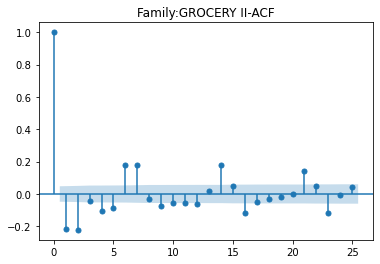

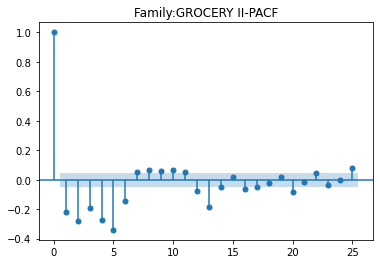

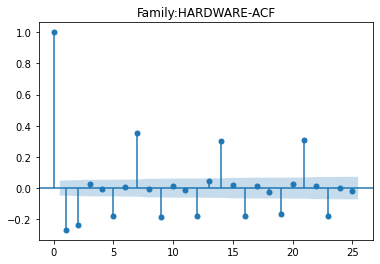

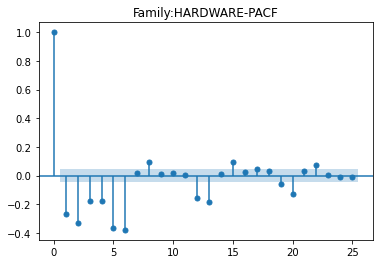

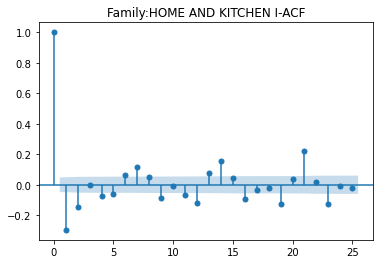

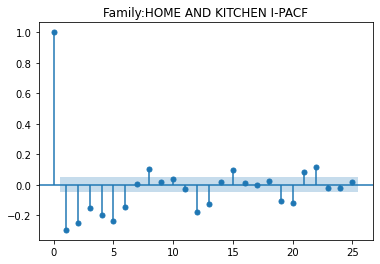

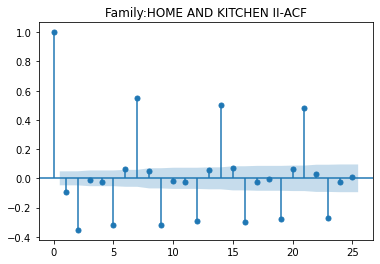

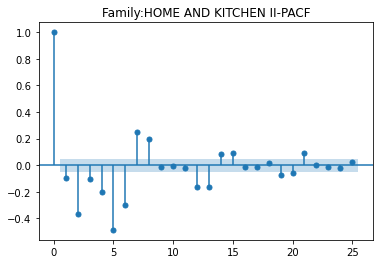

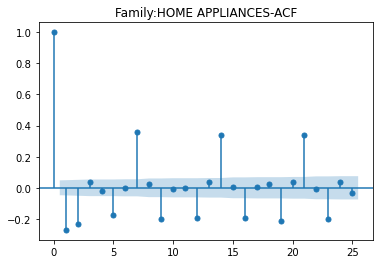

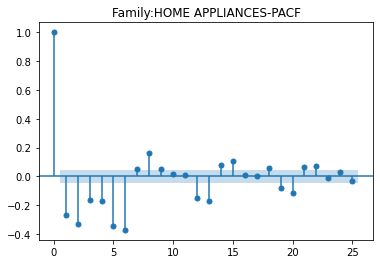

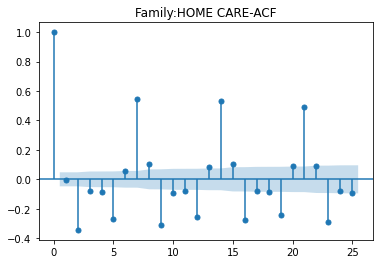

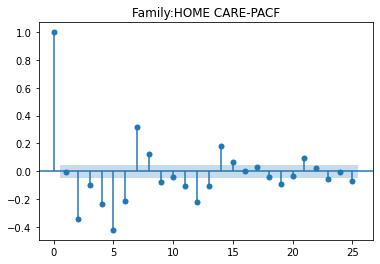

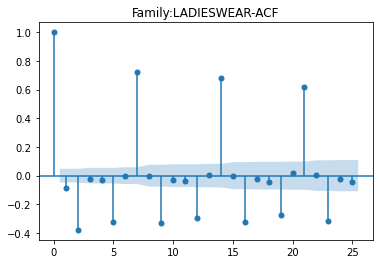

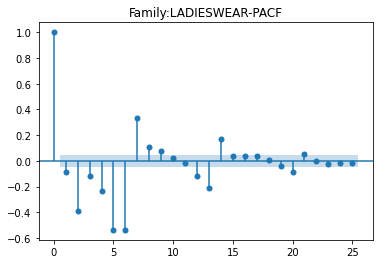

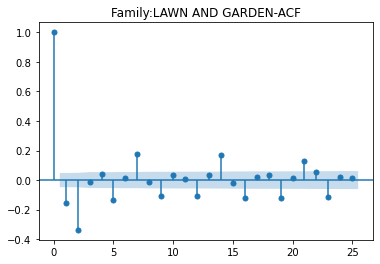

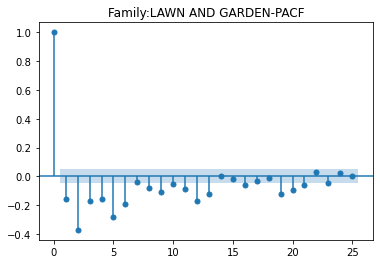

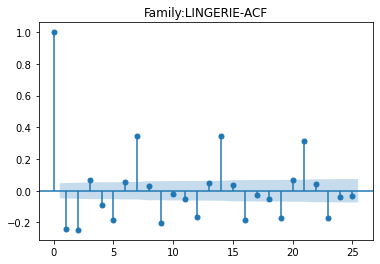

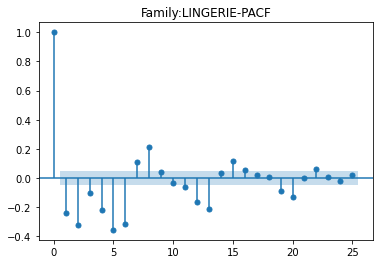

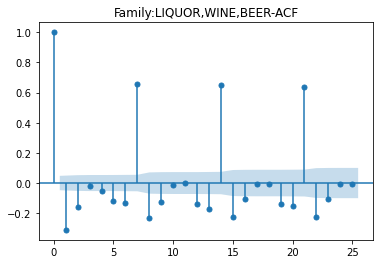

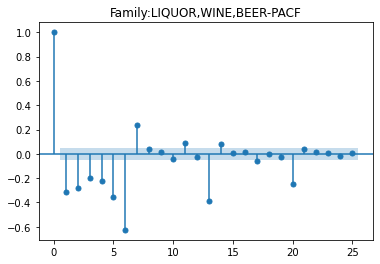

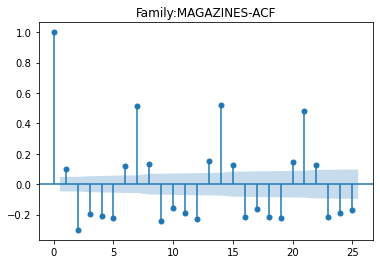

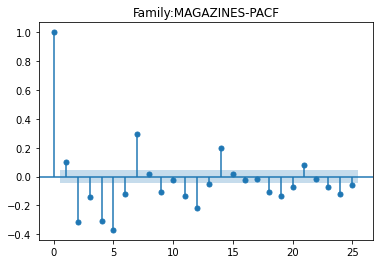

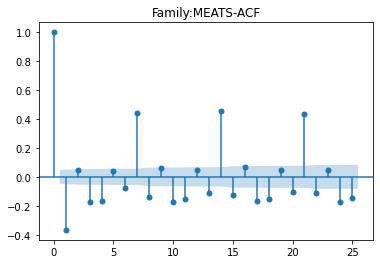

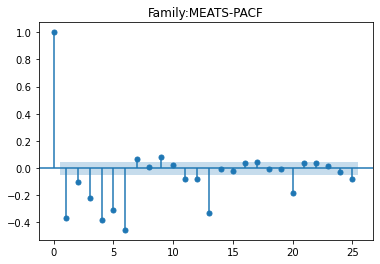

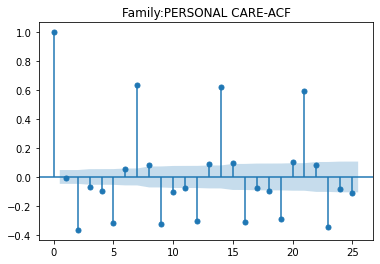

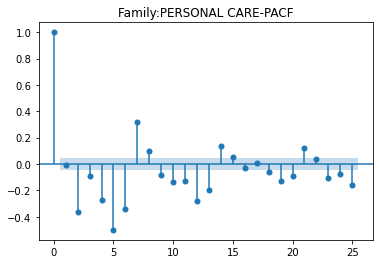

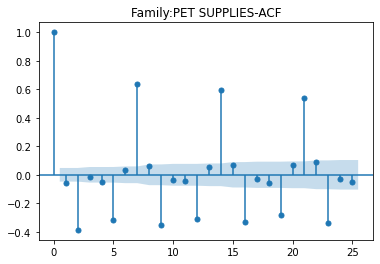

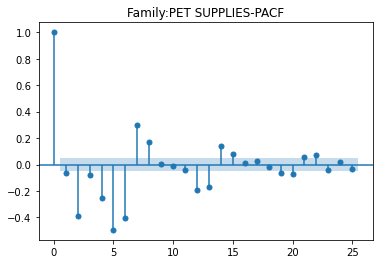

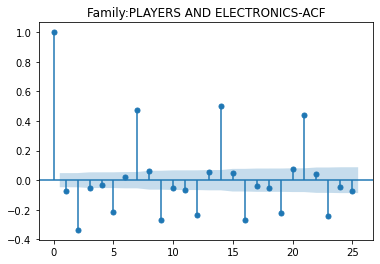

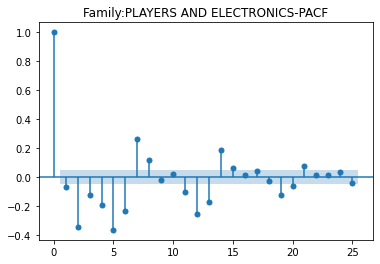

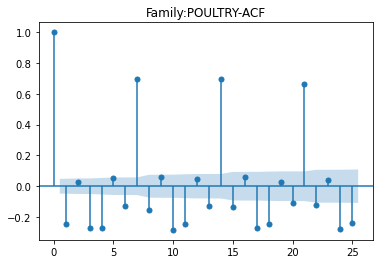

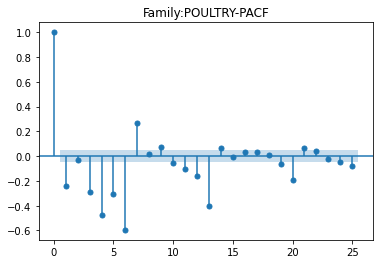

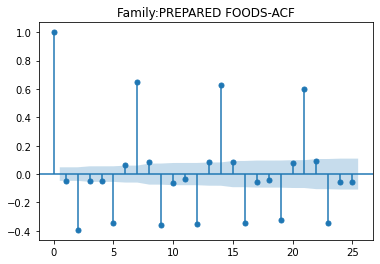

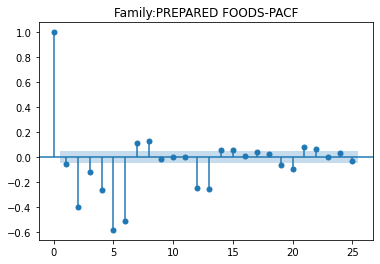

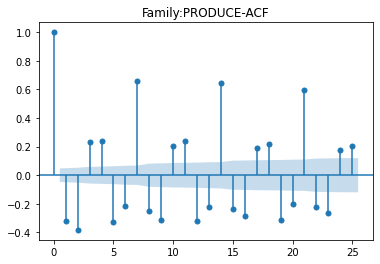

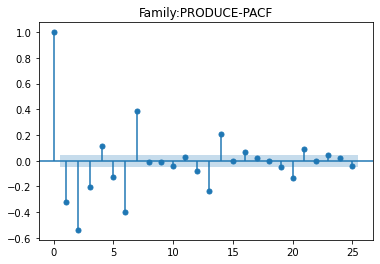

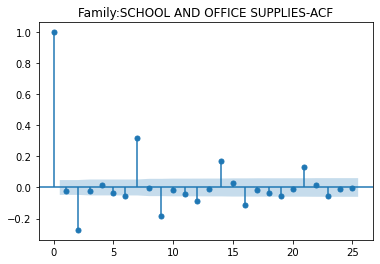

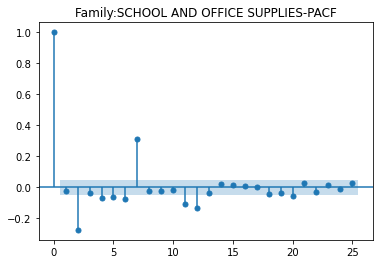

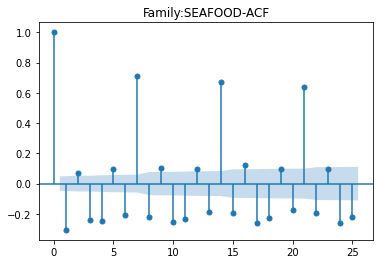

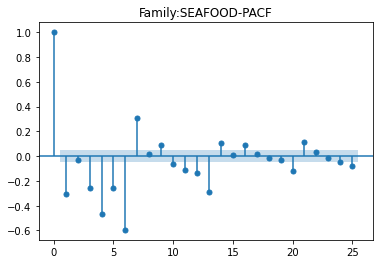

In [23]:
for i in family_list:
    plot_acf(difference1[i], lags=25);
    plt.title('Family:'+str(i)+'-ACF')
    plot_pacf(difference1[i], lags=25);
    plt.title('Family:'+str(i)+'-PACF')

In [16]:
# Finding Best ARIMA model for ever one of family

# order_list=[]
# for i in family_list:
#     auto_arima_model=auto_arima(timeseries[i],trace=False,seasonal=True,
#                      stepwise=True, suppress_warnings=True,error_action='ignore')
#     order_list.append(auto_arima_model.order)
# order_list

In [21]:
residuals=pd.DataFrame()
for i in family_list:    
    Model_1= ARIMA(difference1[i], order=(8,1,2))
    Model_1_fit =Model_1.fit()
    residuals[str(i)] = pd.DataFrame(Model_1_fit.resid)

C:\Users\okanc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\okanc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\okanc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\okanc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no ass

C:\Users\okanc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\okanc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\okanc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\okanc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no ass

C:\Users\okanc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\okanc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\okanc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\okanc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no ass

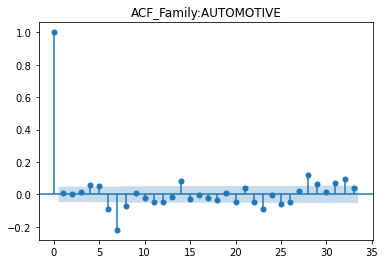

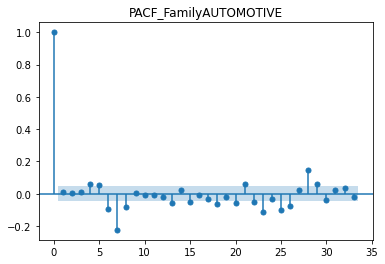

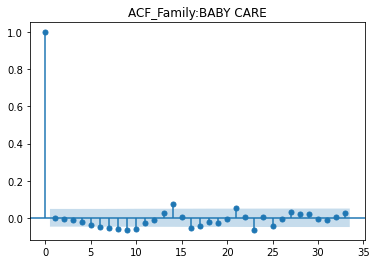

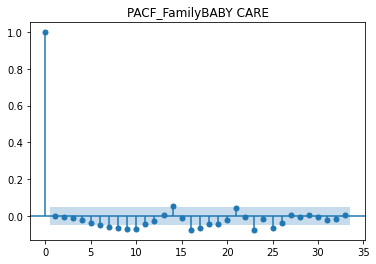

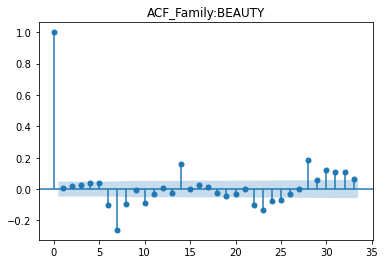

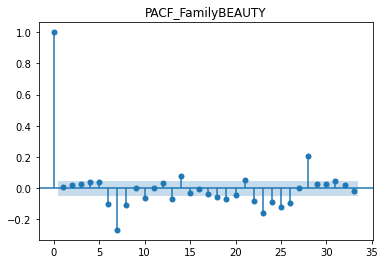

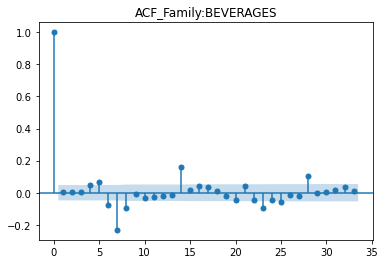

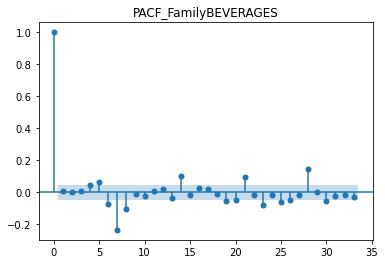

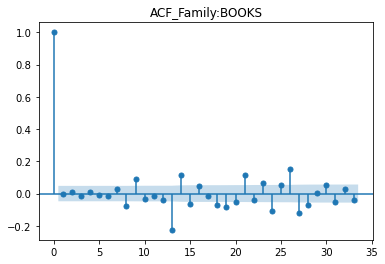

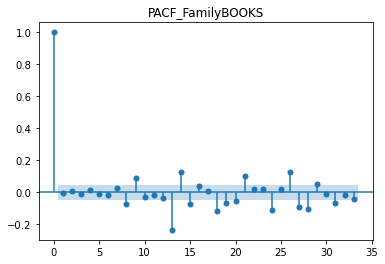

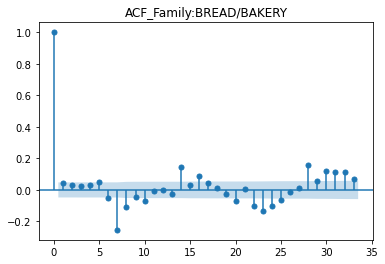

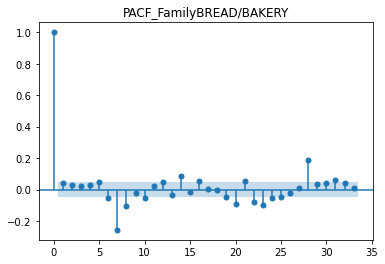

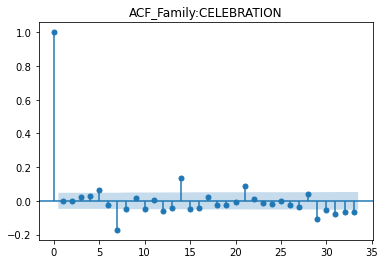

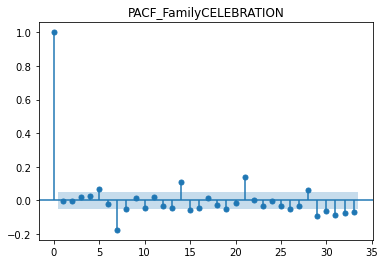

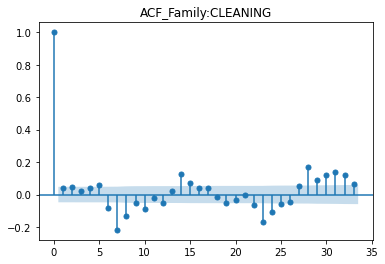

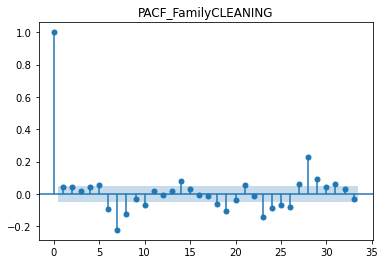

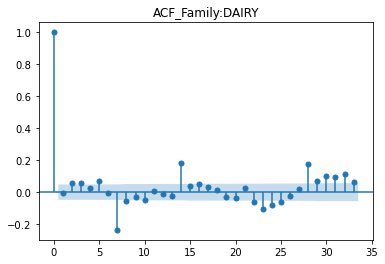

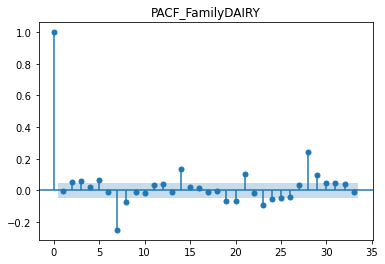

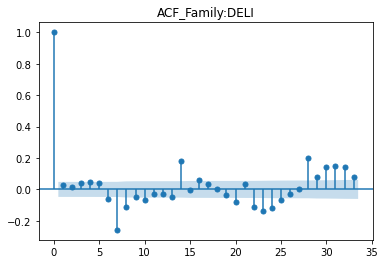

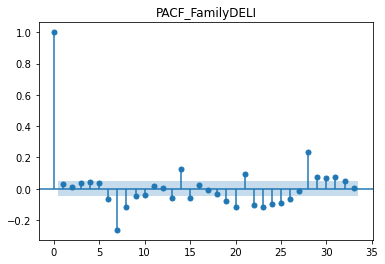

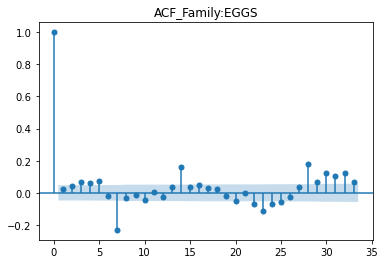

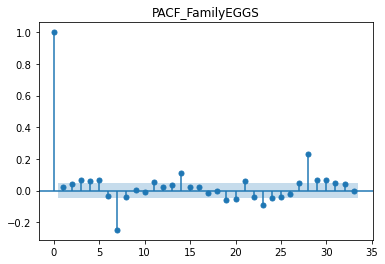

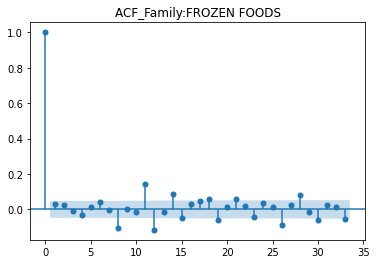

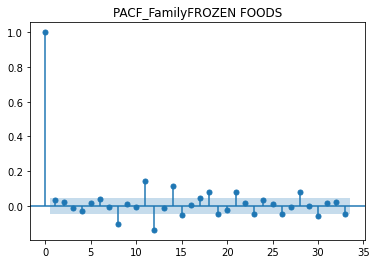

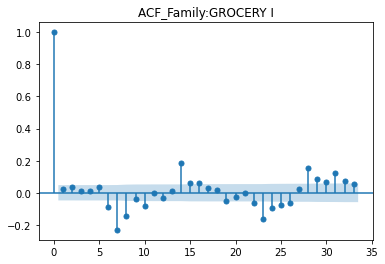

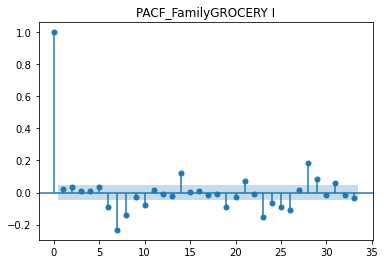

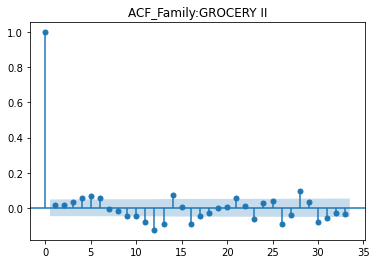

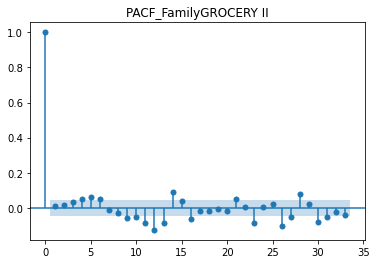

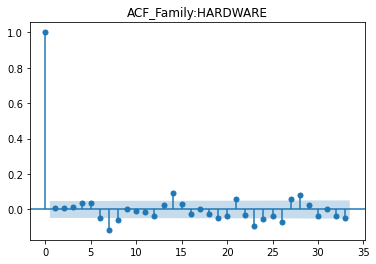

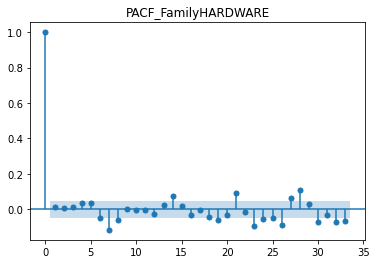

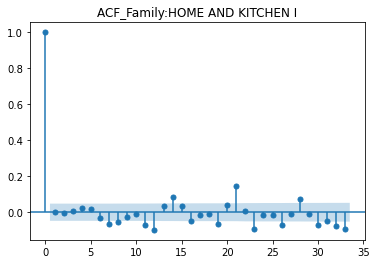

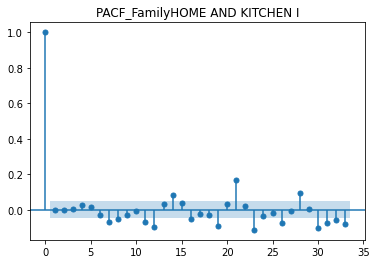

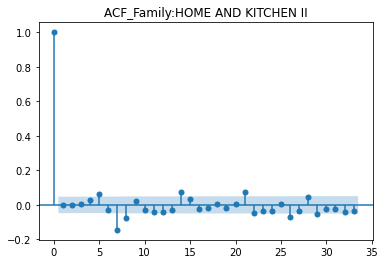

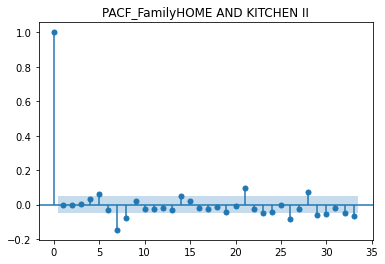

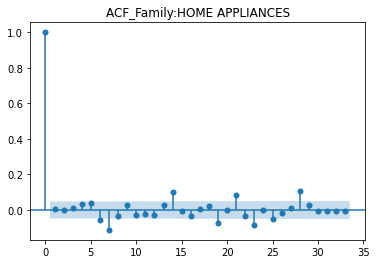

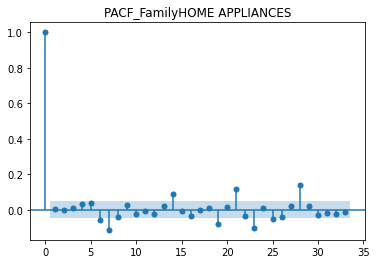

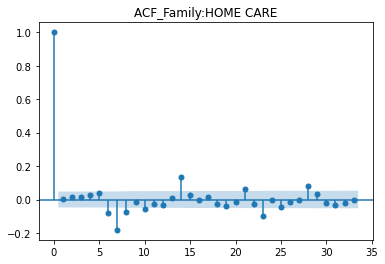

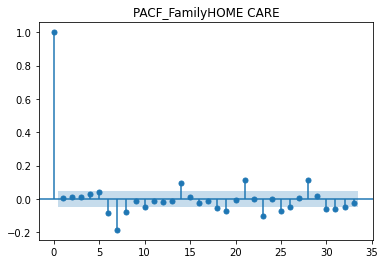

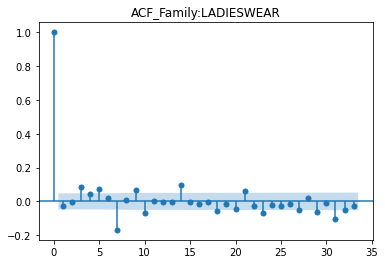

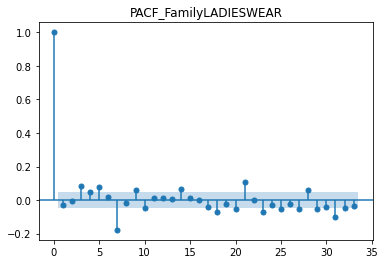

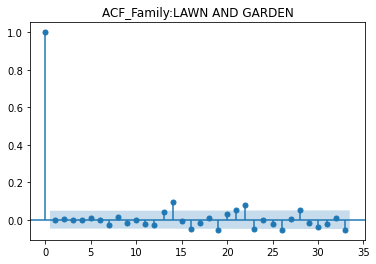

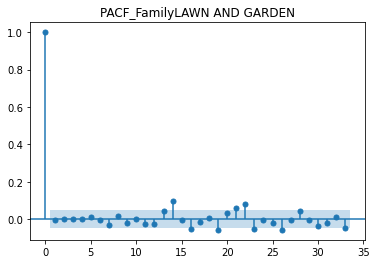

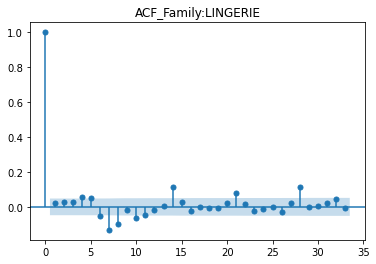

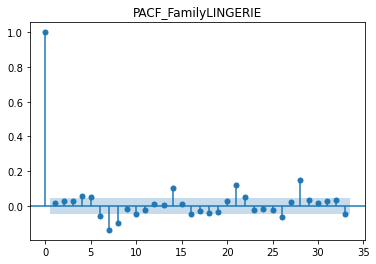

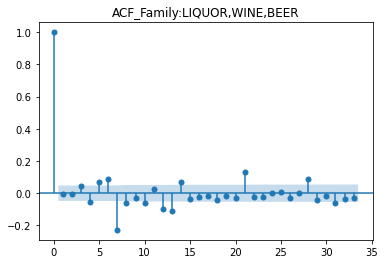

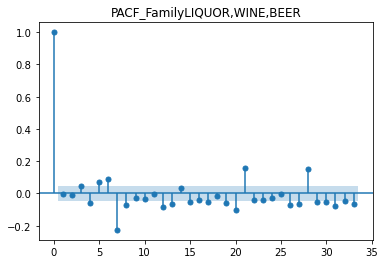

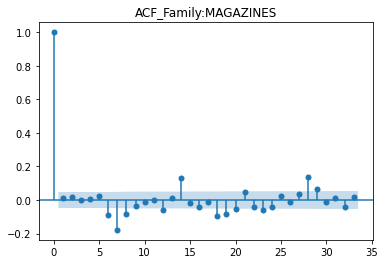

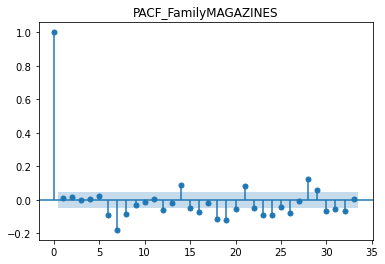

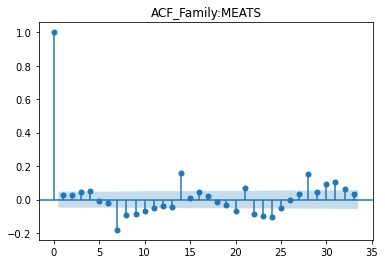

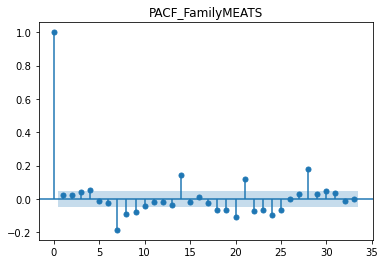

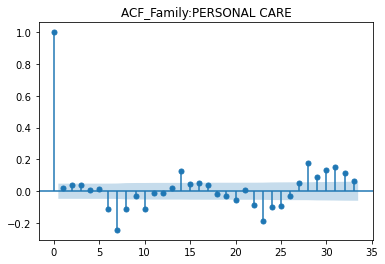

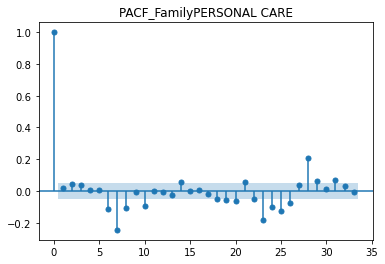

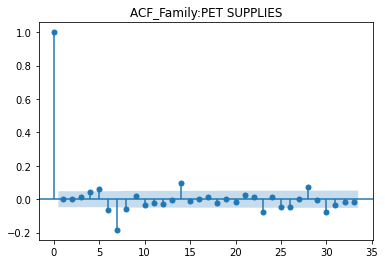

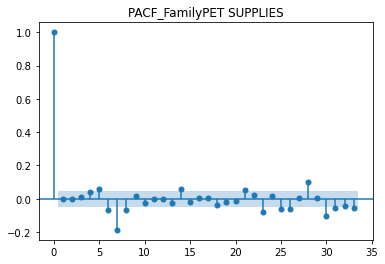

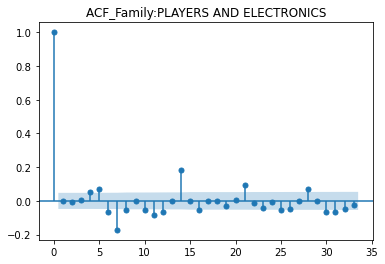

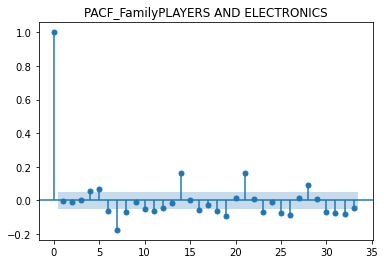

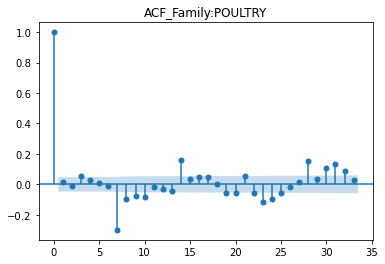

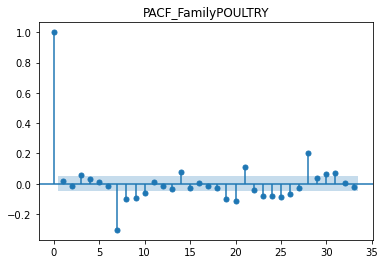

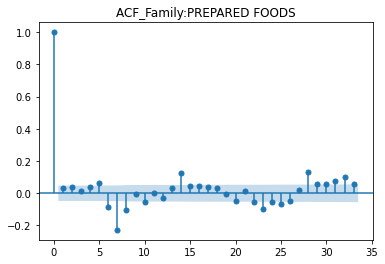

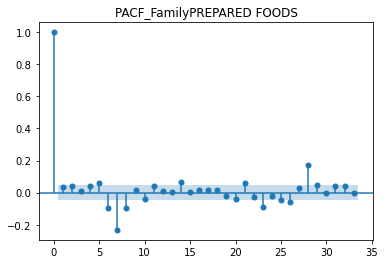

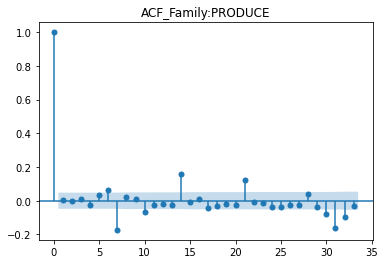

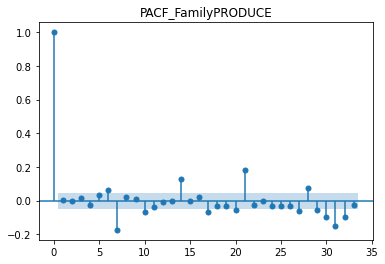

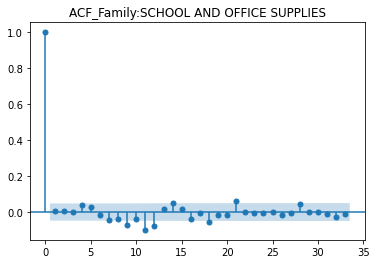

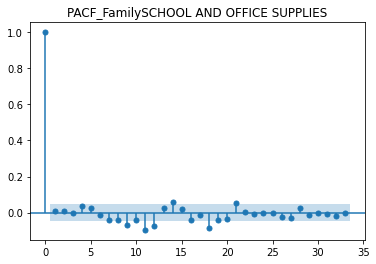

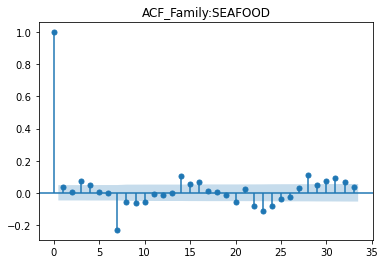

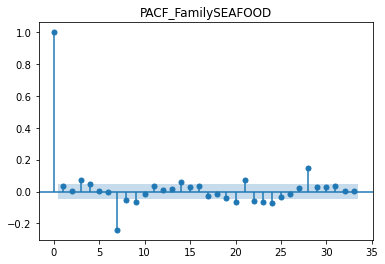

In [23]:
for i in family_list:
    plot_acf(residuals[i], title='ACF_Family:'+i);
    plot_pacf(residuals[i], title='PACF_Family'+i);
    plt.show()

In [68]:
start_point=len(train_data)
end_point=len(train_data)+len(test_data)
Model_2= ARIMA(timeseries[family_list[0]], order=(5,1,2))
Model_fit=Model_2.fit()
predict=Model_fit.predict()

C:\Users\okanc\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\okanc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

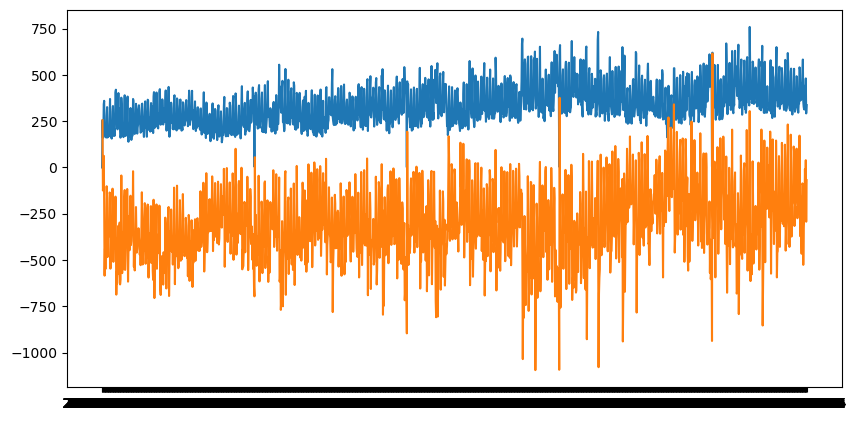

In [77]:
prediction=pd.Series(predict)
prediction=prediction.cumsum()
difference=pd.Series(difference1['AUTOMOTIVE'])
prediction_log=prediction.add(difference,fill_value=0)
fig, axes = plt.subplots(figsize=(10,5), dpi=100, sharex=True)
plt.plot(timeseries['AUTOMOTIVE'])
plt.plot(prediction_log)
plt.show()

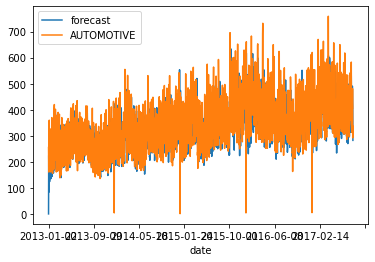

In [78]:
Model_fit.plot_predict(dynamic=False)
plt.show()

In [52]:
Model_2= ARIMA(difference1[family_list[2]], order=(8, 1, 2))
Model_2_fit =Model_2.fit()
# fc, se, conf = Model_2_fit.forecast(15, alpha=0.05)  # 95% conf

# Make as pandas series
# fc_series = pd.Series(fc)
# lower_series = pd.Series(conf[:, 0])
# upper_series = pd.Series(conf[:, 1])
# fc_series

# plt.figure(figsize=(10,5))
# plt.plot(train_data[family_list[1]], label='training')
# # plt.plot(test, label='actual')
# plt.plot(fc_series, label='forecast')
# plt.fill_between(lower_series.index, lower_series, upper_series, 
#                  color='k', alpha=.15)
# plt.title('Forecast vs Actuals')
# plt.legend(loc='upper left', fontsize=8)
# plt.show()

C:\Users\okanc\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\okanc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

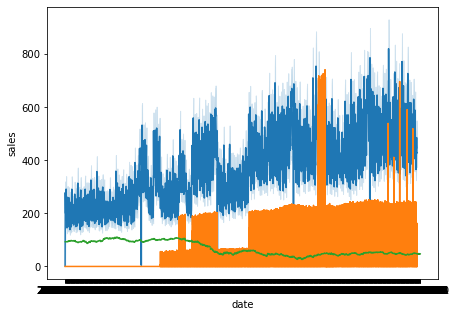

In [7]:
fig,ax=plt.subplots(figsize=(7,5))
sns.lineplot(data=train_data, 
             x='date', 
             y='sales')
ax.plot(train_data['date'],train_data['onpromotion'])
ax.plot(oil_data['date'],oil_data['dcoilwtico'])
plt.show()

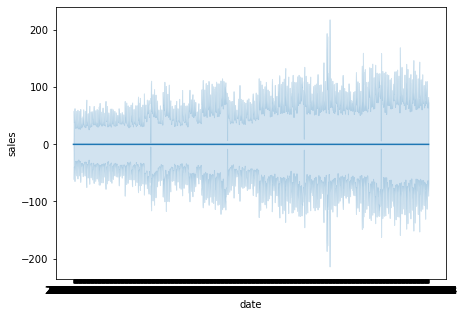

In [56]:
difference1=train_data['sales'].diff(periods=1)
difference1=difference1[1:]

fig,ax=plt.subplots(figsize=(7,5))
sns.lineplot(x=train_data['date'], 
             y=difference1)
# ax.plot(train_data['date'],train_data['onpromotion'])
# ax.plot(oil_data['date'],oil_data['dcoilwtico'])
plt.show()

In [57]:
train_data['difference1']=difference1
train_data.tail()

,id,date,store_nbr,family,sales,onpromotion,difference1
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,432.133
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,-283.580
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,2265.176
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,-2298.729
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0,-105.000


In [ ]:
plot_acf(train_data['difference1'], lags=25);

In [44]:
sales=train_data.groupby(['store_nbr','date'],as_index=False).agg(sales=('sales','sum'))
sales

,store_nbr,date,sales
0,1,2013-01-01,0.000000
1,1,2013-01-02,7417.148000
2,1,2013-01-03,5873.244001
3,1,2013-01-04,5919.879001
4,1,2013-01-05,6318.785010
...,...,...,...
90931,54,2017-08-11,8513.834000
90932,54,2017-08-12,9139.678002
90933,54,2017-08-13,14246.827996
90934,54,2017-08-14,11882.994000


In [43]:
family_list=list(set(train_data['family']))
len(family_list)

33

In [15]:
montly_sale.groupby('store_nbr').sum().round(2)

,sales
store_nbr,
1,14145012.87
2,21557388.64
3,50481910.19
4,18909700.38
5,15592404.57
6,25183680.00
7,26952049.58
8,30494286.93
9,26409441.06


Seems like none of the stores are closed during almost for four years

In [28]:
# timeseries=train_data.groupby(['store_nbr','date','id'],as_index=False).agg(sales=('sales','sum'))
# timeseries

,store_nbr,date,id,sales
0,1,2013-01-01,0,0.000
1,1,2013-01-01,1,0.000
2,1,2013-01-01,2,0.000
3,1,2013-01-01,3,0.000
4,1,2013-01-01,4,0.000
...,...,...,...,...
3000883,54,2017-08-15,3000751,59.619
3000884,54,2017-08-15,3000752,94.000
3000885,54,2017-08-15,3000753,915.371
3000886,54,2017-08-15,3000754,0.000
